## Dataset Chosen:
Sakar,C. and Kastro,Yomi. (2018). Online Shoppers Purchasing Intention Dataset. 

UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.

## Introduction 

In this case we aim to build a model using K Nearest Neighbors to predict whether a website visitor will make a purchase.  Our target value it 'True' or 'False' depending on what we predict their intention to be.

When making a prediction for a two-class classification problem, there are two types of errors the model can make:

    False Positive. Predict an event when there was no event (eg: the visitor will not make a purchase).
    False Negative. Predict no event when in fact there was an event (eg: the visitor will make a purchase).

By predicting probabilities and calibrating a threshold based on accuracy and recall (aka: sensitivity), a balance of these two concerns can be chosen to help us limit risks of bad predictions with our model.

In [209]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config("figure")

In [178]:
sessions = pd.read_csv('data/online_shoppers_intention.csv')

In [179]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [180]:
sessions.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [203]:
# No missing data, although the data is posted without missing data good to check anyway: 
#Count total NaN on each column in a DataFrame, we have a lot missing and can drop a few:
print(f" \nMissing or Null Value Count: \n\n{sessions.isna().sum()}\n")

 
Missing or Null Value Count: 

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64



In [182]:
# some of our functions (eg: precision_recall_curve) like to receive data all as object or all as a bool,
#here we convert to object/string for this purpose 
sessions['Revenue'] = sessions['Revenue'].replace({True: 'True', False: 'False'})
sessions['Weekend'] = sessions['Weekend'].replace({True: 'True', False: 'False'})
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [183]:
#data tranformation: convert Month, visitor and Weekend to numeric values using ohe, scale the rest
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['Month', 'VisitorType', 'Weekend']),
                                     remainder = StandardScaler())
#split into training and test data for features X and target Revenue True or False y 
X_train, X_test, y_train, y_test = train_test_split(sessions.drop('Revenue', axis = 1), sessions.Revenue,
                                                   random_state=42,
                                                   stratify = sessions.Revenue)

In [204]:
# let's start with a base model and check our predictions & probabilities output right
knn_pipe = Pipeline([
    ('transform', transformer), 
    ('knn', KNeighborsClassifier(n_neighbors = 10))
])
knn_pipe
knn_pipe.fit(X_train, y_train)
test_predictions = knn_pipe.predict_proba(X_test)
test_predictions

array([[0.8, 0.2],
       [0.8, 0.2],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [0.9, 0.1],
       [0.9, 0.1]])

In [212]:
knn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Month', 'VisitorType',
                                                   'Weekend'])])),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


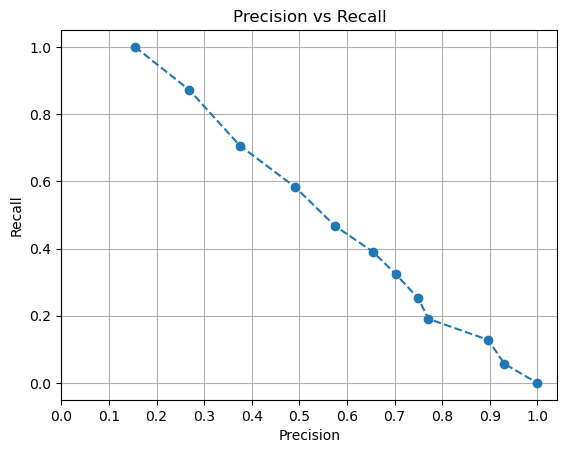

In [207]:
#could do manually but use scikit Learns precision_recall_curve rather than build out our own DF & plot
#this takes different thresholds and works out what would be +ve above that value so we can find opt params
#note we 0th column of test predictions will be 'False' probabilities so selecting 1st col 'True' to 
#compare to y_test 'real'values'
precision, recall, boundaries = precision_recall_curve(y_test, test_predictions[:, 1], pos_label='True')
print(boundaries[:10])
plt.plot(precision, recall, '--o')
plt.xticks(boundaries);
plt.grid()
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall');

False Positive Rates:  [0.         0.00076746 0.00268611 0.01036071 0.01534919]
True Positive Rates:  [0.         0.05660377 0.1278826  0.19077568 0.25157233]


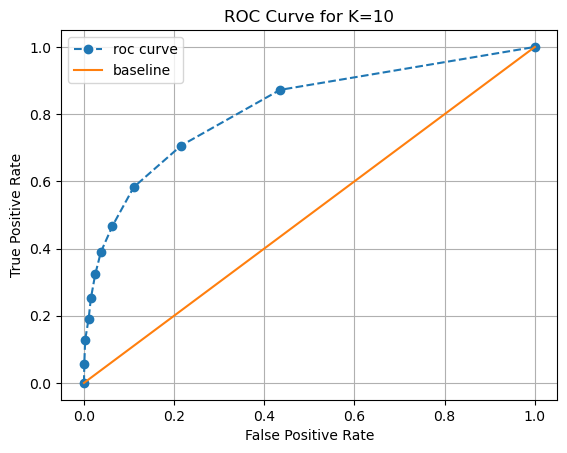

In [197]:
#ROC Curve, similar but subjectively better than above as easier to read
fpr, tpr, thresh_rocs = roc_curve(y_test, test_predictions[:, 1], pos_label='True')

print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve for K=10')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

In [192]:
#let's use a grid search CV to find optimal K value
roc_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors': range(1, 63, 2)}, scoring = 'roc_auc')
roc_grid.fit(X_train, y_train)
best_k = roc_grid.best_params_['knn__n_neighbors']
best_k

47

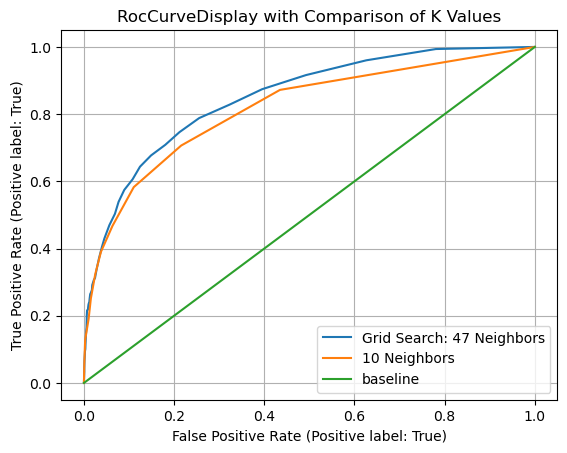

In [202]:
#let's chart out our ROC Curve with optimal K's to see what thresholds might be best to use
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(roc_grid, X_test, y_test, pos_label = 'True', ax = ax, label = 'Grid Search: 47 Neighbors')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, pos_label = 'True', ax = ax, label = '10 Neighbors')
#RocCurveDisplay.from_estimator(knn_1, X_test, y_test, ax = ax, label = '1 Neighbor')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('RocCurveDisplay with Comparison of K Values')
plt.legend();

## Conclusion
For our case there is no catastrophic outcome if we wrongly predict a false positive (aka we predict a person will make a purchase but they don't).  Let's say we use this data to trigger sales and marketing activities, in this case the better tradeoff to capture all potential customers would be to reduce the amount of False negatives, and maybe have a few more False positives. We would do this by selecting a threshold on the lower end say 0.4. Essentially a low precision and high recall or in other words we have an optimistic classifier. On the other hand if we have limited product and a very costly sales follow up process we would want the inverse and have high precision and low recall.     